In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [9]:
# df = pd.read_csv("question4-stock-data.csv")
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# print(df.head())

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [12]:
df = pd.read_csv("cleaned_data.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(df.head())

        Date       Close        High         Low        Open    Volume
0 2017-01-03  118.550003  118.669998  117.830002  118.169998  204000.0
1 2017-01-04  121.190002  121.290001  120.139999  120.269997  250600.0
2 2017-01-05  120.440002  121.389999  120.320000  121.190002  525900.0
3 2017-01-06  120.129997  120.230003  119.410004  119.839996  171600.0
4 2017-01-09  119.739998  119.959999  119.470001  119.480003  135800.0


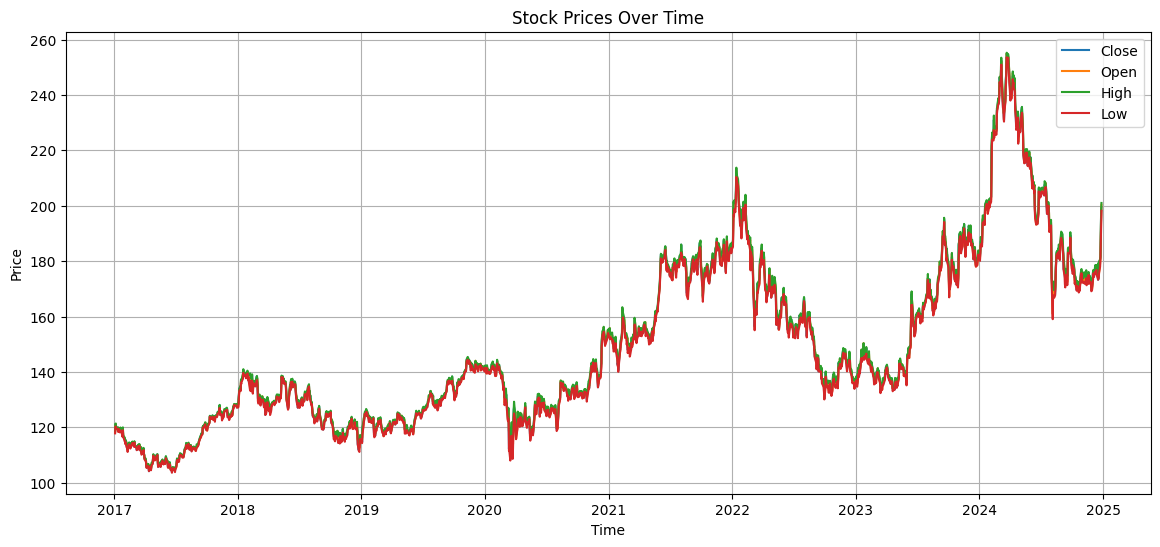

In [13]:
# prompt: i need to plot Close, Open, High, Low with Time

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['Open'], label='Open')
plt.plot(df['Date'], df['High'], label='High')
plt.plot(df['Date'], df['Low'], label='Low')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
def engineer_multi_output_features(df, ignore=None):
    """
    Create features and multi-output targets for predicting the next 5 closing prices.
    Uses `pd.concat` to avoid DataFrame fragmentation.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with OHLCV data
    ignore : list, optional
        List of column names to exclude from the returned features

    Returns:
    --------
    pandas.DataFrame
        DataFrame with all original and engineered features, except those in ignore list
    """
    df = df.copy()
    feature_cols = ['Close', 'Low', 'High', 'Volume']

    # Prepare dictionary to store all new features
    new_features = {}

    # Create rolling means, lagged features, percentage changes, and differences
    for col in feature_cols:
        for window in [2, 3, 5, 7]:
            new_features[f'{col}_RollingMean_window{window}'] = df[col].rolling(window=window).mean()

        for lag in  [1, 3, 5, 7]:
            new_features[f'{col}_lag{lag}'] = df[col].shift(lag)
            new_features[f'{col}_PctChange_lag{lag}'] = df[col].pct_change(periods=lag)
            new_features[f'{col}_Diff_lag{lag}'] = df[col].diff(periods=lag)

    # Add custom features
    new_features['High_Low'] = df['High'] - df['Low']
    new_features['High_Volume'] = df['High'] * df['Volume']
    new_features['Volume_Diff_lag1'] = df['Volume'] - df['Volume'].shift(1)
    new_features['Volume_Close_Diff'] = (df['Volume'] - df['Volume'].shift(1)) * (df['Close'] - df['Close'].shift(1))

    # Generate lagged features for custom features from lag 1 to 3
    custom_feature_cols = ['Volume_Diff_lag1']
    for col in custom_feature_cols:
        for lag in  [1, 3]:  # Generate lags from 1 to 3
            new_features[f'{col}_lag{lag}'] = new_features[col].shift(lag)

    # Add day of week and other time-based features
    new_features['DayOfWeek'] = df.index.dayofweek
    new_features['Month'] = df.index.month
    new_features['Year'] = df.index.year
    new_features['WeekOfYear'] = df.index.isocalendar().week

    # Create multi-output targets (next 5 closing prices)
    for i in range(1, 6):
        new_features[f'Target_Close_t+{i}'] = df['Close'].shift(-i)

    # Combine original and new features using pd.concat to avoid fragmentation
    combined_df = pd.concat([df, pd.DataFrame(new_features, index=df.index)], axis=1)

    # Drop rows with NaN values
    combined_df.dropna(inplace=True)

    # Filter out columns to ignore if specified
    if ignore is not None:
        columns_to_keep = [col for col in combined_df.columns if col not in ignore]
        combined_df = combined_df[columns_to_keep]

    return combined_df

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_predictions(y_test, y_pred, output_columns, sample_size=200):
    """
    Visualize predicted vs actual values for multi-output regression.
    Each subplot represents one of the target columns (e.g., next 5 days' predictions).
    Displays the results with improved readability.

    - Uses scatter plot to reduce clutter.
    - Samples data if too large for clear visualization.
    - Formats x-axis for better date representation.
    """
    plt.figure(figsize=(12, 18))

    # Sample indices for plotting if data is too large
    if len(y_test) > sample_size:
        sample_indices = np.linspace(0, len(y_test) - 1, sample_size, dtype=int)
    else:
        sample_indices = np.arange(len(y_test))

    for i, col in enumerate(output_columns):
        plt.subplot(len(output_columns), 1, i + 1)

        # Scatter plot to avoid line clutter
        plt.scatter(y_test.index[sample_indices], y_test.iloc[sample_indices, i], label='Actual', color='blue', s=10)
        plt.scatter(y_test.index[sample_indices], y_pred[sample_indices, i], label='Predicted', color='red', s=10)

        plt.title(f'Prediction vs Actual for {col}')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()

        # Format the x-axis to show only the month and day
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

        plt.grid(True)
        plt.tight_layout()

    plt.show()


In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
from sklearn.model_selection import train_test_split
import pandas as pd

def prepare_data_for_training(
    df: pd.DataFrame,
    output_columns: list,
    ignore_columns: list = None,
    test_size: float = 0.2,
    random_state: int = 42
):
    """
    Prepare data for training a machine learning model by engineering features,
    separating features and targets, and splitting into train and test sets.

    Args:
        df (pd.DataFrame): The input DataFrame with historical data.
        output_columns (list): List of target column names (e.g., future closing prices).
        ignore_columns (list, optional): Columns to ignore as features. Defaults to None.
        test_size (float, optional): Proportion of the dataset to include in the test split. Defaults to 0.2.
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets ready for model training.
    """
    # Define columns to ignore if not provided
    if ignore_columns is None:
        ignore_columns = []

    # Engineer features (assuming engineer_multi_output_features is already defined)
    processed_df = engineer_multi_output_features(df, ignore=ignore_columns)

    # Identify feature columns (exclude target and ignored columns)
    feature_columns = [
        col for col in processed_df.columns
        if col not in output_columns and col not in ignore_columns
    ]

    # Separate features and targets
    X = processed_df[feature_columns]
    y = processed_df[output_columns]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )

    print(f"Training data size: {X_train.shape[0]} rows")
    print(f"Testing data size: {X_test.shape[0]} rows")
    print(f"Number of features: {len(feature_columns)}")

    return X_train, X_test, y_train, y_test


In [56]:
# Assuming 'stock_data' is your DataFrame with OHLCV data
stock_data = pd.read_csv('cleaned_data.csv', parse_dates=['Date'], index_col='Date')

# Define which columns to predict
output_columns = ['Target_Close_t+1', 'Target_Close_t+2', 'Target_Close_t+3', 'Target_Close_t+4', 'Target_Close_t+5']

# Define columns to ignore (these won't be used as features)
ignore_columns = ['Date', 'Month', 'Year']

# Prepare the data
X_train, X_test, y_train, y_test = prepare_data_for_training(
    df=stock_data,
    output_columns=output_columns,
    ignore_columns=ignore_columns,
    test_size=0.2,
    random_state=42
)
# print(X_train.head())
# print(y_train.head())
print(X_train.columns)
print(y_train.columns)
print(len(X_train.columns))
print(len(y_train.columns))

Training data size: 1511 rows
Testing data size: 378 rows
Number of features: 76
Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Close_RollingMean_window2',
       'Close_RollingMean_window3', 'Close_RollingMean_window5',
       'Close_RollingMean_window7', 'Close_lag1', 'Close_PctChange_lag1',
       'Close_Diff_lag1', 'Close_lag3', 'Close_PctChange_lag3',
       'Close_Diff_lag3', 'Close_lag5', 'Close_PctChange_lag5',
       'Close_Diff_lag5', 'Close_lag7', 'Close_PctChange_lag7',
       'Close_Diff_lag7', 'Low_RollingMean_window2', 'Low_RollingMean_window3',
       'Low_RollingMean_window5', 'Low_RollingMean_window7', 'Low_lag1',
       'Low_PctChange_lag1', 'Low_Diff_lag1', 'Low_lag3', 'Low_PctChange_lag3',
       'Low_Diff_lag3', 'Low_lag5', 'Low_PctChange_lag5', 'Low_Diff_lag5',
       'Low_lag7', 'Low_PctChange_lag7', 'Low_Diff_lag7',
       'High_RollingMean_window2', 'High_RollingMean_window3',
       'High_RollingMean_window5', 'High_RollingMean_window7', 'High_lag1',
     

In [67]:
# # Define a smaller parameter grid for RandomForestRegressor
# param_grid = {
#     'n_estimators': [42, 45], # 45, 48, 50, 52, 55
#     'max_depth': [8], # 6, 10, 12
#     # 'min_samples_split': [2, 3], # put later
#     'min_samples_leaf': [4], # put 2, 3, 5
#     'max_features': ['sqrt', 0.15]  # 0.2, 0.5
# }

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define a smaller parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [42, 45], # 45, 48, 50, 52, 55
    'max_depth': [8], # 6, 10, 12
    # 'min_samples_split': [2, 3], # put later
    'min_samples_leaf': [4], # put 2, 3, 5
    'max_features': ['sqrt', 0.15]  # 0.2, 0.5
}

# Create the GridSearchCV object with verbose output
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # Use 3-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Show progress during grid search
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8], 'max_features': ['sqrt', 0.2],
                         'min_samples_leaf': [4],
                         'n_estimators': [42, 45, 48]},
             scoring='neg_mean_squared_error', verbose=2)

In [63]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score (negative MSE): {best_score:.4f}")

# Train the model with the best parameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)


Best parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 42}
Best score (negative MSE): -142.7737


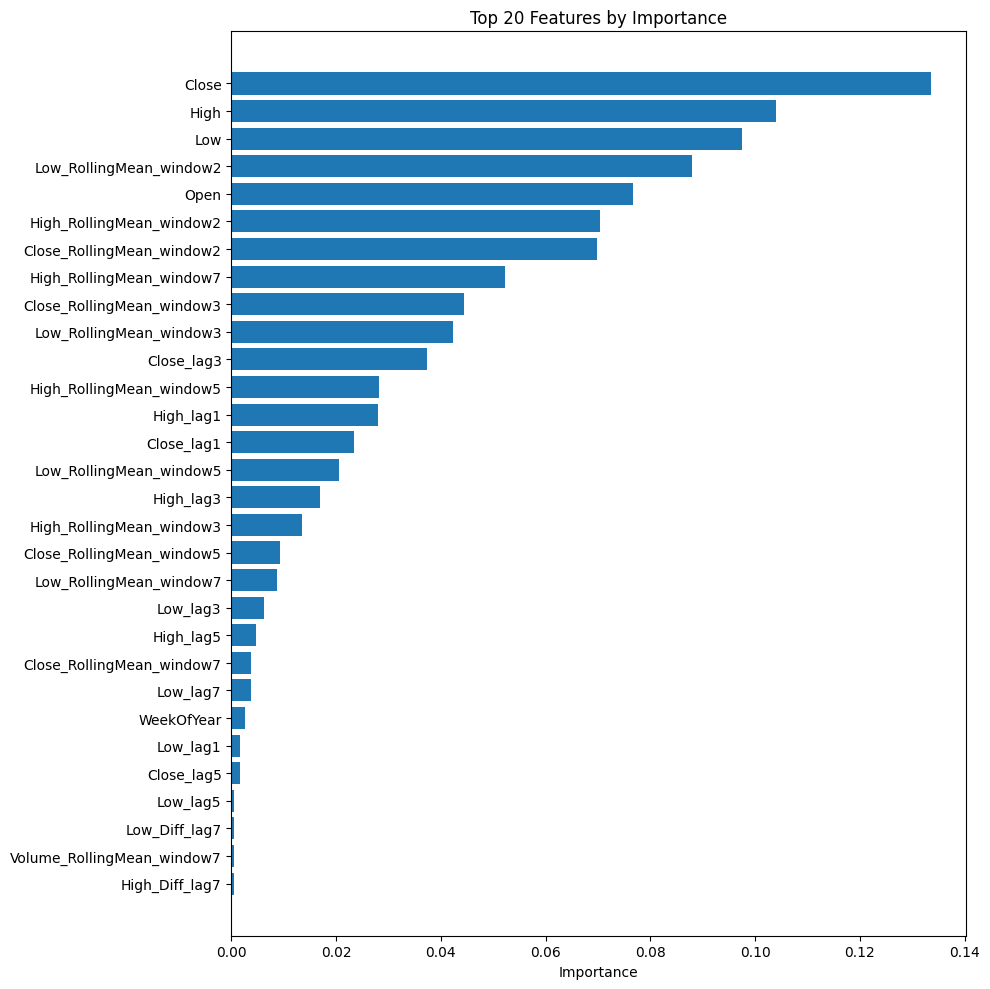

In [64]:
# Get feature importances
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualize top features
plt.figure(figsize=(10, 10))
top_features = importance_df.head(30)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [65]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics for each target
for i, col in enumerate(output_columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

Target_Close_t+1: RMSE = 17.4322, R² = 0.5253
Target_Close_t+2: RMSE = 17.9984, R² = 0.4899
Target_Close_t+3: RMSE = 18.5712, R² = 0.4530
Target_Close_t+4: RMSE = 19.2324, R² = 0.4083
Target_Close_t+5: RMSE = 19.7078, R² = 0.3736


```
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.25, 20]  # Include fractions and fixed numbers
}

.....

param_grid = {
    'n_estimators': [50],
    'max_depth': [10, 15],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 3],
    'max_features': ['sqrt', 0.5]  # Include fractions and fixed numbers
}
Round 1:
Target_Close_t+1: RMSE = 17.3087, R² = 0.5320
Target_Close_t+2: RMSE = 17.8879, R² = 0.4962
Target_Close_t+3: RMSE = 18.6399, R² = 0.4490
Target_Close_t+4: RMSE = 19.2844, R² = 0.4051
Target_Close_t+5: RMSE = 19.7892, R² = 0.3684

Round 2: - After decreasing cols
Target_Close_t+1: RMSE = 17.9116, R² = 0.4989
Target_Close_t+2: RMSE = 18.5459, R² = 0.4584
Target_Close_t+3: RMSE = 19.3635, R² = 0.4054
Target_Close_t+4: RMSE = 20.0297, R² = 0.3582
Target_Close_t+5: RMSE = 20.5497, R² = 0.3190

After Param improv:
Target_Close_t+1: RMSE = 17.4654, R² = 0.5235
Target_Close_t+2: RMSE = 18.1385, R² = 0.4820
Target_Close_t+3: RMSE = 18.8760, R² = 0.4349
Target_Close_t+4: RMSE = 19.5269, R² = 0.3900
Target_Close_t+5: RMSE = 20.1313, R² = 0.3464

Furthur:
Target_Close_t+1: RMSE = 17.4322, R² = 0.5253
Target_Close_t+2: RMSE = 17.9984, R² = 0.4899
Target_Close_t+3: RMSE = 18.5712, R² = 0.4530
Target_Close_t+4: RMSE = 19.2324, R² = 0.4083
Target_Close_t+5: RMSE = 19.7078, R² = 0.3736
```


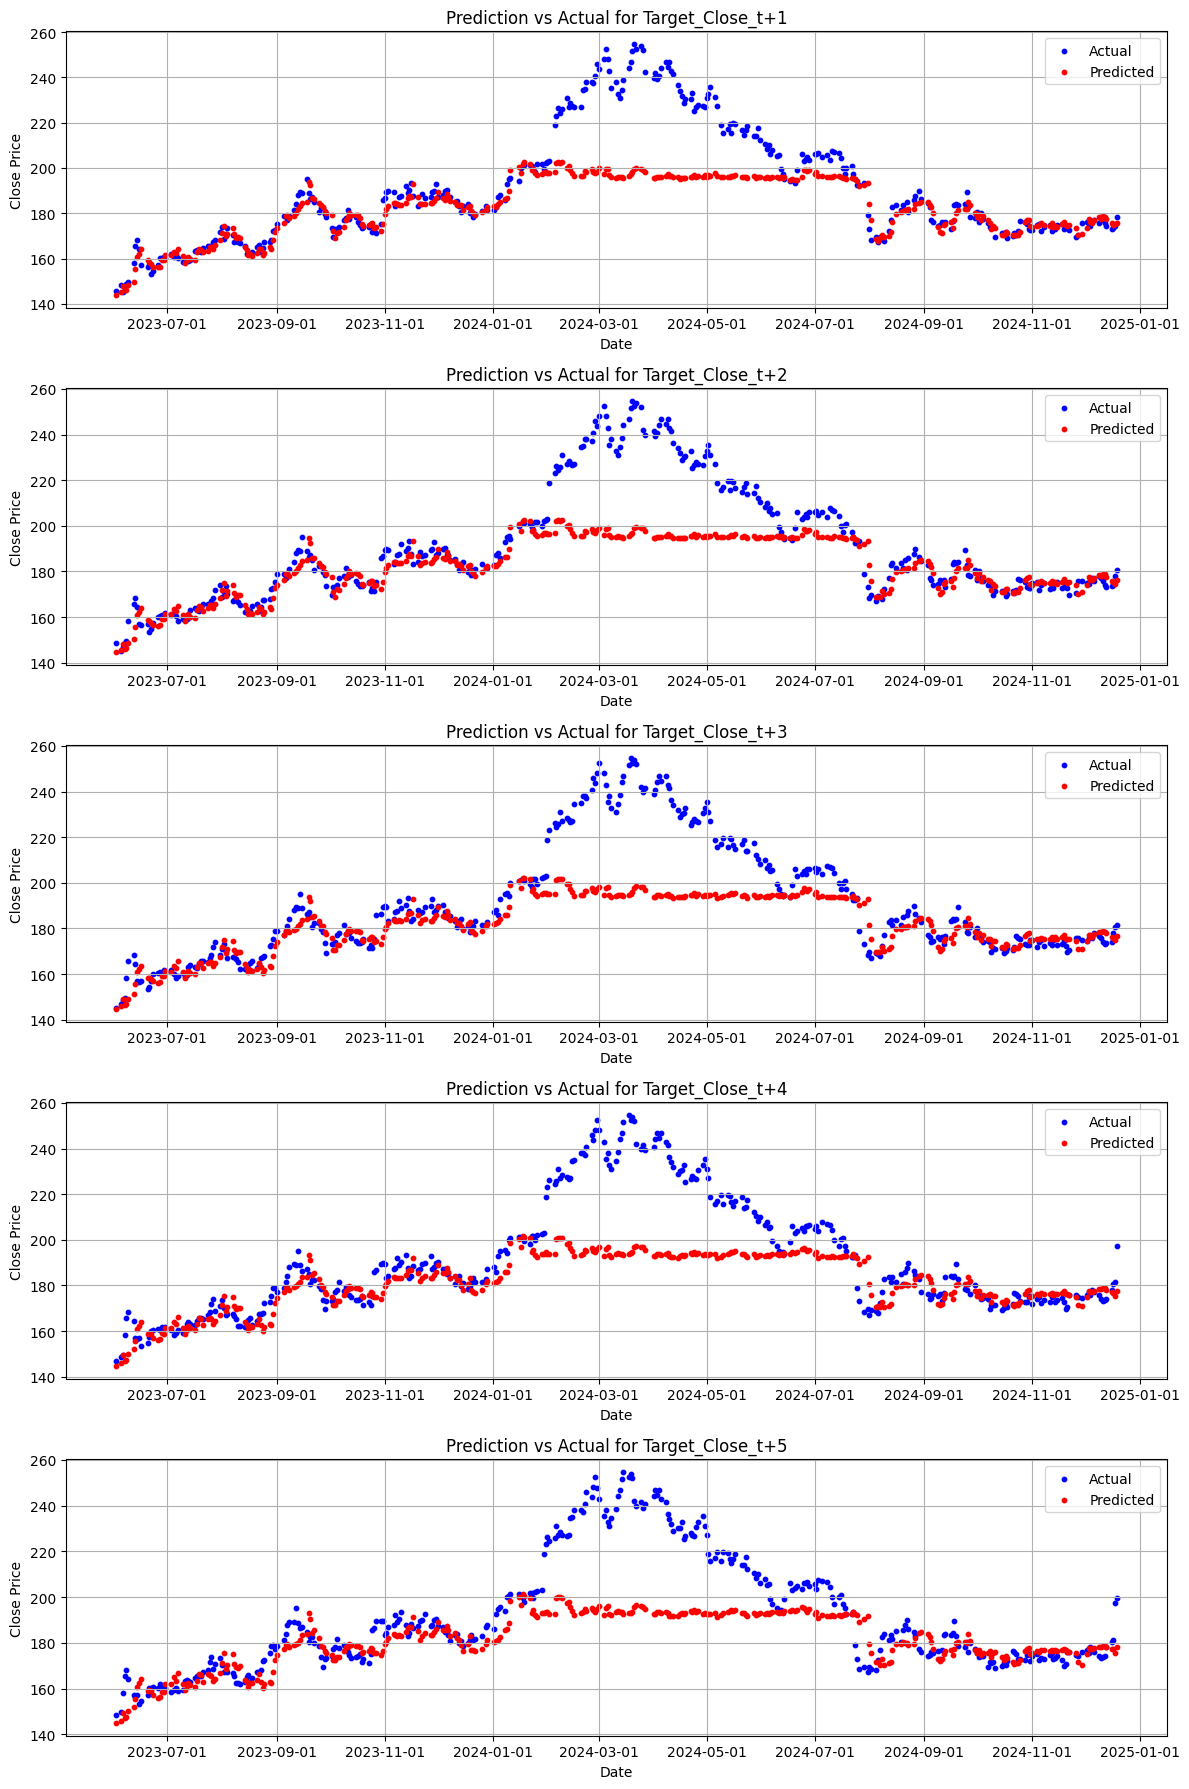

In [66]:
# Call the function to plot predictions
plot_predictions(y_test, y_pred, output_columns, sample_size=400)

In [69]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

# Use RandomizedSearchCV instead of GridSearchCV for faster execution
# Define a parameter distribution that covers similar space but samples fewer combinations
# param_dist = {
#     'n_estimators': [42, 45],
#     'max_depth': [8, 10],
#     'learning_rate': [0.05, 0.1],  # Added learning rate parameter
#     'subsample': [0.8, 0.9],       # Added subsample parameter for faster training
#     'colsample_bytree': [0.8, 0.9] # Added column sampling for efficiency
# }
param_dist = {
    'n_estimators': [42, 45], # 42
    'max_depth': [8, 10], # 10
    'learning_rate': [0.05, 0.1],  # Added learning rate parameter - 0.05
    'subsample': [0.8, 0.9],       # Added subsample parameter for faster training - 0.8
    'colsample_bytree': [0.8, 0.9] # Added column sampling for efficiency - 0.8
}

# Create the RandomizedSearchCV object with proper verbose output
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist',        # Using histogram-based algorithm (much faster)
        verbosity=1                # XGBoost specific verbosity
    ),
    param_distributions=param_dist,
    n_iter=5,                      # Only try 5 random combinations
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=3,                     # Higher verbosity (3 instead of 2)
    return_train_score=True
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best MSE: {-random_search.best_score_:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 45, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best MSE: 170.5650


In [71]:
# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score (negative MSE): {best_score:.4f}")

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

Best parameters: {'subsample': 0.9, 'n_estimators': 45, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best score (negative MSE): -170.5650


In [72]:
# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics for each target
for i, col in enumerate(output_columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

Target_Close_t+1: RMSE = 21.3475, R² = 0.2882
Target_Close_t+2: RMSE = 22.4803, R² = 0.2043
Target_Close_t+3: RMSE = 23.3021, R² = 0.1389
Target_Close_t+4: RMSE = 24.5168, R² = 0.0384
Target_Close_t+5: RMSE = 23.8726, R² = 0.0809


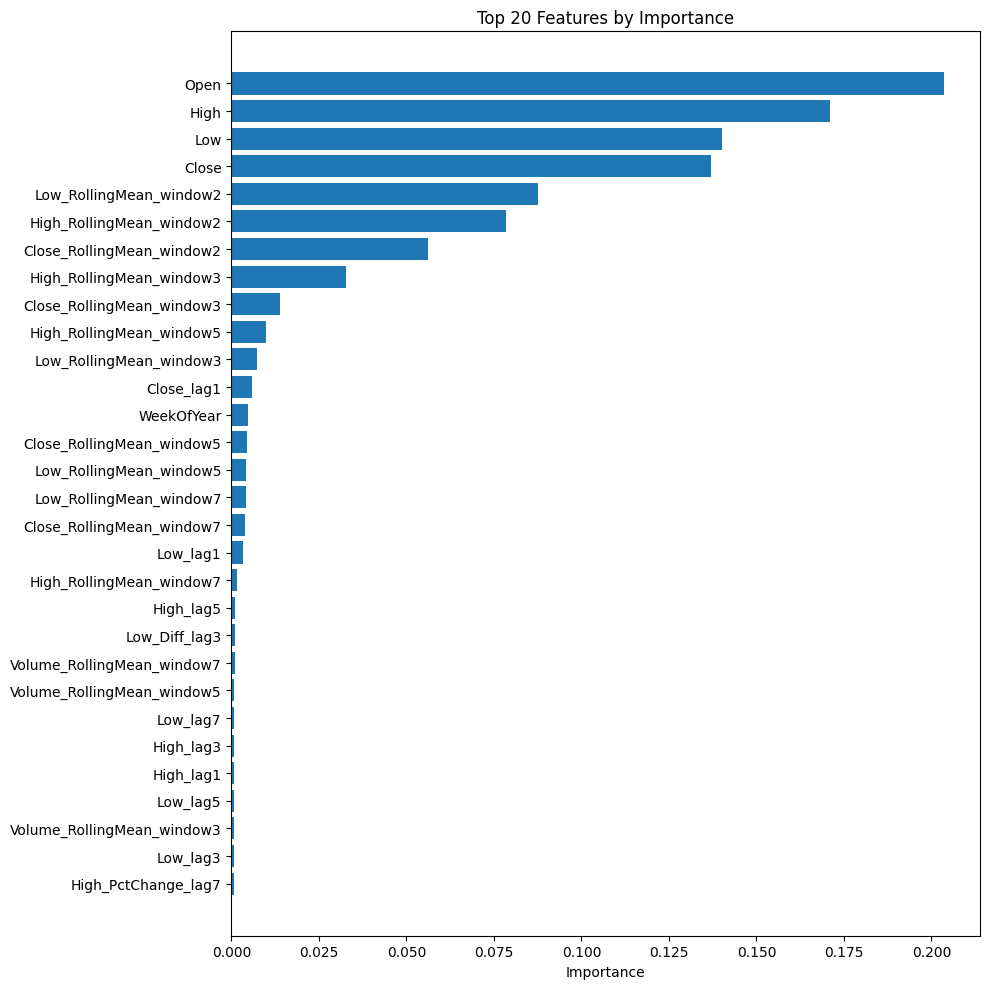

In [73]:
# Get feature importances
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualize top features
plt.figure(figsize=(10, 10))
top_features = importance_df.head(30)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

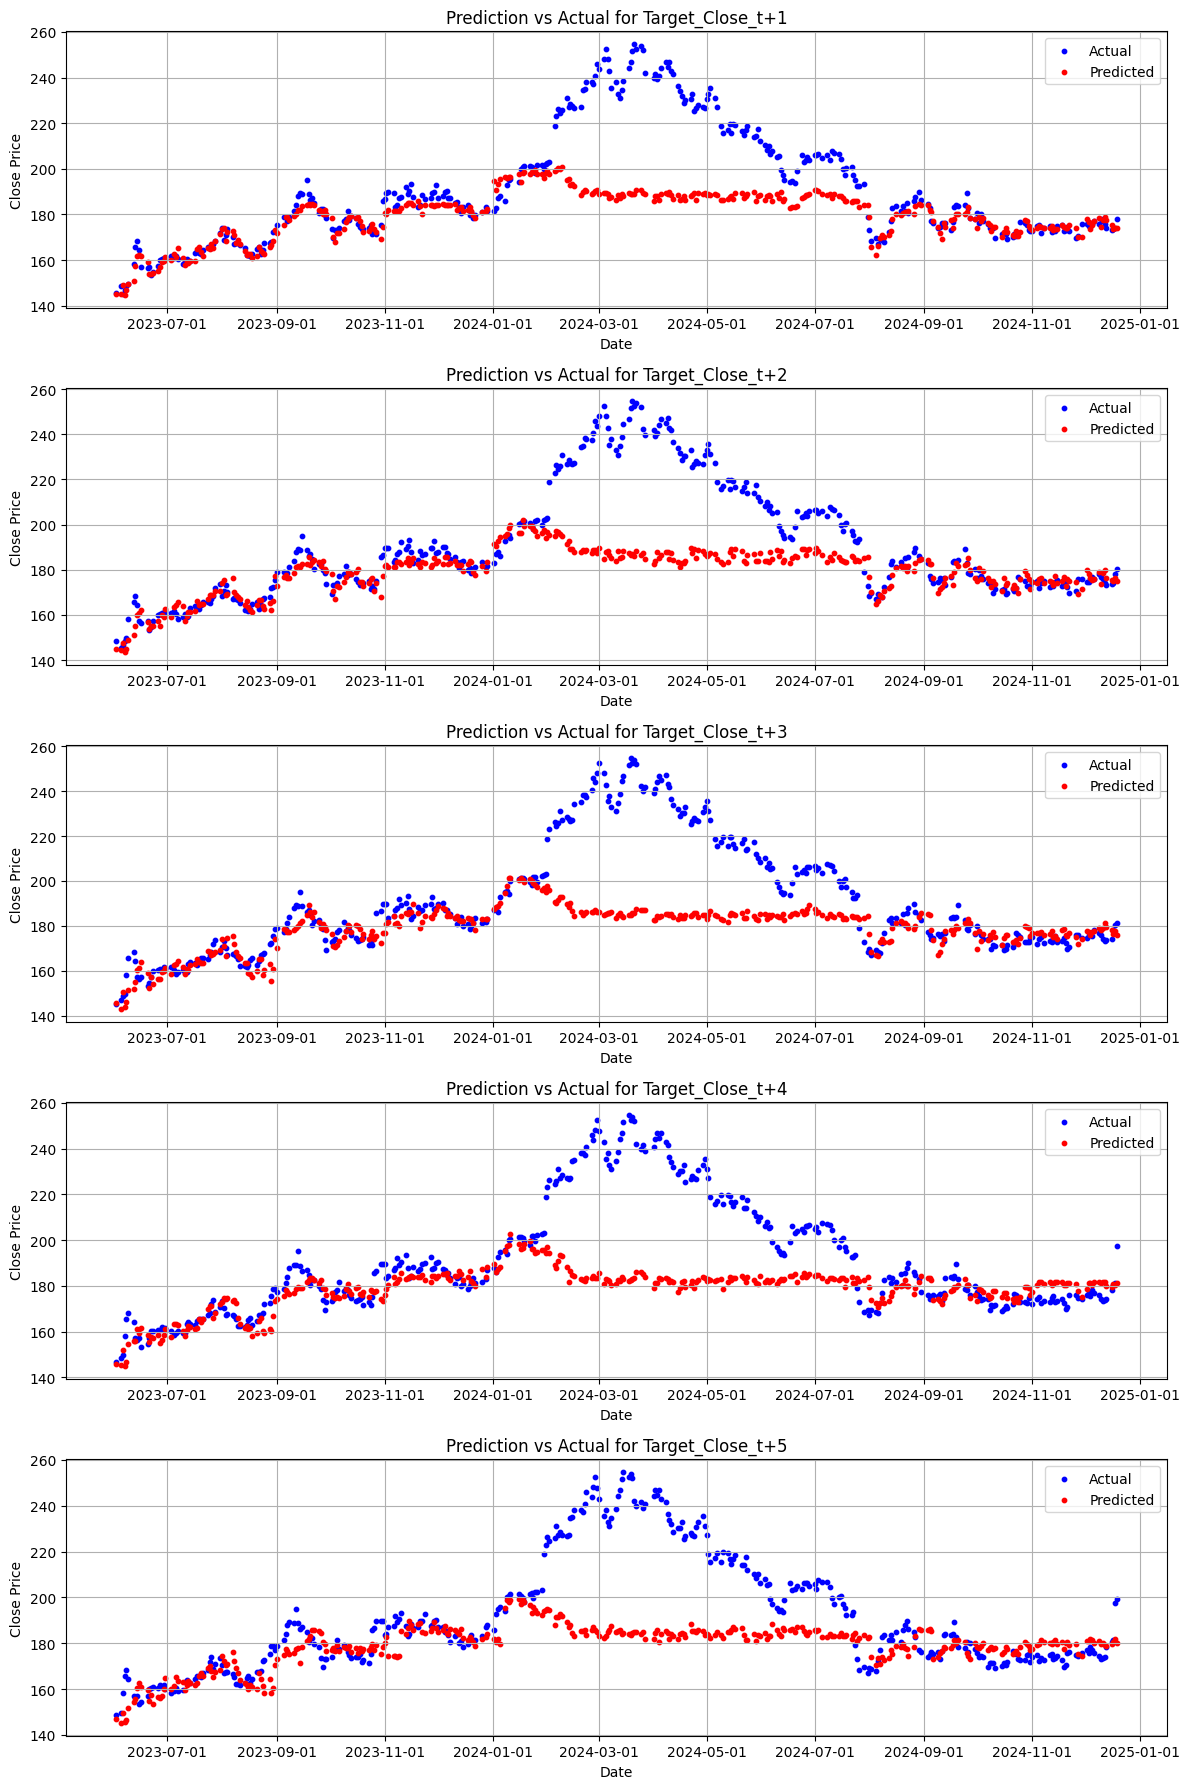

In [74]:
plot_predictions(y_test, y_pred, output_columns, sample_size=400)

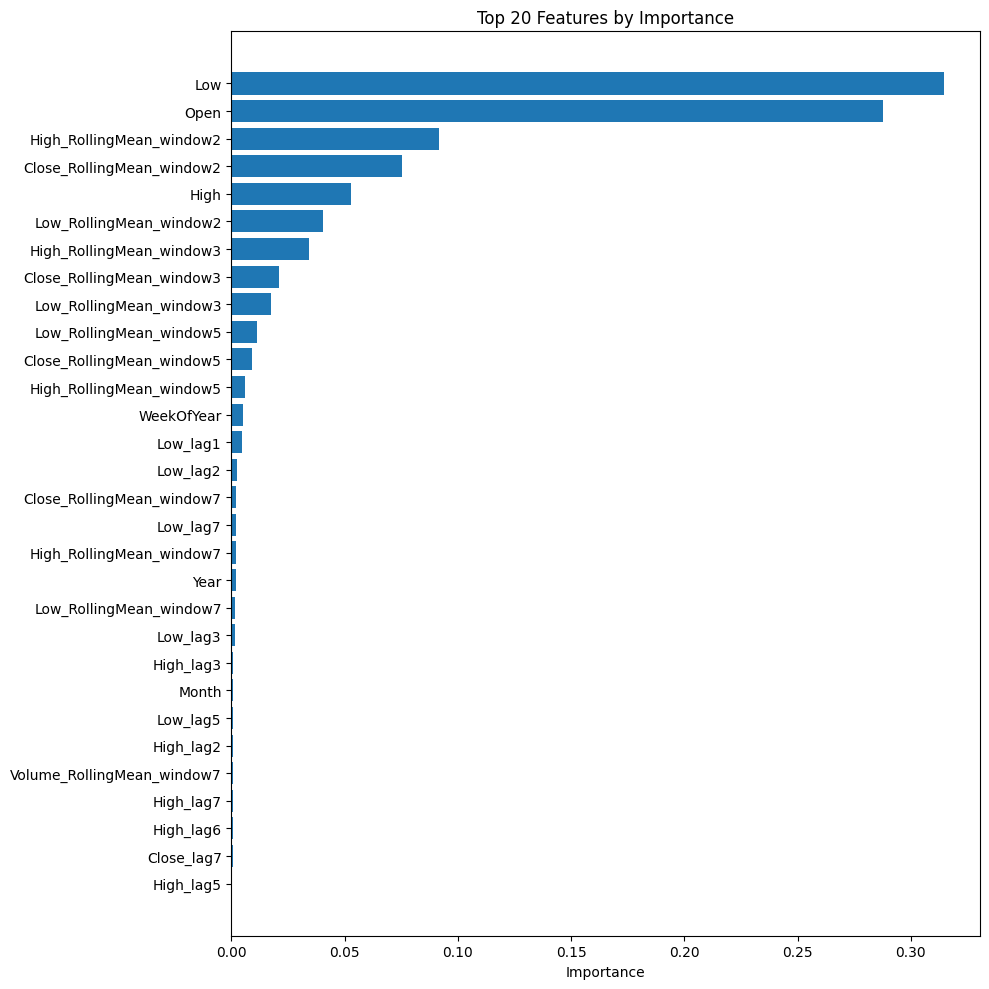

                      Feature  Importance
1                         Low    0.314817
2                        Open    0.287851
26   High_RollingMean_window2    0.091823
4   Close_RollingMean_window2    0.075402
0                        High    0.052644
15    Low_RollingMean_window2    0.040435
27   High_RollingMean_window3    0.034439
5   Close_RollingMean_window3    0.021075
16    Low_RollingMean_window3    0.017671
17    Low_RollingMean_window5    0.011297
6   Close_RollingMean_window5    0.009240
28   High_RollingMean_window5    0.005915
67                 WeekOfYear    0.005068
19                   Low_lag1    0.004923
20                   Low_lag2    0.002629
7   Close_RollingMean_window7    0.002202
25                   Low_lag7    0.002051
29   High_RollingMean_window7    0.002045
66                       Year    0.001882
18    Low_RollingMean_window7    0.001817


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# def identify_best_features(df, target_prefix='Target_Close_t+'):
#     """
#     Trains a basic XGBoost model to assess feature importance.
#     Focuses on identifying which features contribute most to predicting the target.
#     """
#     # Separate features and targets
#     target_cols = [col for col in df.columns if col.startswith(target_prefix)]
#     feature_cols = [col for col in df.columns if col not in target_cols and col not in ['Close']]

#     X = df[feature_cols]
#     y = df[target_cols]

#     # Split the data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize XGBoost model for feature importance analysis
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Get feature importances
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    # Visualize top features
    plt.figure(figsize=(10, 10))
    top_features = importance_df.head(30)
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 20 Features by Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return importance_df

# Example usage
file_path = "cleaned_data.csv"  # Update with your file path
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
df = engineer_multi_output_features(df)
importance_df = identify_best_features(df)

# Display the top 20 features
print(importance_df.head(20))
